In [25]:
import os
from getpass import getpass
import asyncio
import platform
import base64
from datetime import datetime
import argparse
from langchain import hub
import random
import time
import json
import re
from io import BytesIO
from langchain_openai import AzureChatOpenAI
import PIL.Image
from playwright.async_api import async_playwright, Page
from typing import List, Optional
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.runnables import chain as chain_decorator
from langchain_core.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langgraph.graph import END, START, StateGraph

import warnings
warnings.filterwarnings('ignore')

In [26]:
base_path = '~/Desktop/'
with open(r'config.json') as config_file:
    config_details = json.load(config_file)

# Load config values
openai_api_endpoint = config_details['config_list'][0]['azure_endpoint']

# API version e.g. "2023-07-01-preview"
openai_api_version = config_details['config_list'][0]['api_version']

model_name = config_details['config_list'][0]['model']
# The API key for your Azure OpenAI resource.
openai_api_key = config_details['config_list'][0]['api_key']
# The APItype for your Azure OpenAI resource.
openai_api_type = config_details['config_list'][0]['api_type']


In [27]:
llm = AzureChatOpenAI(
    openai_api_version=openai_api_version,
    azure_endpoint=openai_api_endpoint,
    openai_api_key=openai_api_key,
    openai_api_type=openai_api_type,
    temperature=0.2,
    max_tokens=4096,
    timeout=120,
    max_retries=10,
    model=model_name,
    # other params...
)

def simulate_human_typing(text):
    start = 0
    word_len = len(text)+1
    rand_int = random.randint(1,3)
    end = start + min(rand_int, word_len)

    while True:
        output =  text[start:end]

        start = end
        end = min(start+rand_int, word_len+1)

        yield output

        if end>=word_len+1:
            break


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# Unified state for all agents
class AgentState(TypedDict):
    # Common fields
    page: Page
    input: str
    
    # Browser agent fields
    img: Optional[str]
    bboxes: Optional[List[BBox]]
    prediction: Optional[Prediction]
    scratchpad: Optional[List[BaseMessage]]
    observation: Optional[str]
    
    # Supervisor fields
    browsing_output: Optional[str]
    supervisor_decision: Optional[str]
    final_answer: Optional[str]
    additional_instructions: Optional[str]
    supervisor_assessment: Optional[str]
    
    # Tracking fields
    phase: Optional[str]  # To track which phase we're in: "initial", "browsing", or "evaluation"




In [28]:
async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    for key_strokes in simulate_human_typing(text_content):
        dynamic_delay = random.random()*100
        await page.keyboard.type(key_strokes, delay=dynamic_delay)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"

async def go_to_url(state: AgentState):
    page = state["page"]
    url_args = state["prediction"]["args"]
    if url_args is None or len(url_args) != 1:
        return "Failed to go to URL due to incorrect arguments."
    
    url = url_args[0]
    print("Trying to print",url)
    if not url.startswith("http"):
        url = "https://" + url + "/" # Make sure the URL starts with http or https
    
    await page.goto(url)
    return f"Navigated to {url}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_homepage(state: AgentState):
    page = state["page"]
    await page.goto("https://www.chromium.org")
    return "Navigated to the default home page."

async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

async def summarize_image(state: AgentState):
    """Summarizes an image with a short context of what is displayed."""
    page = state["page"]
    screenshot = await page.screenshot()
    image_url = base64.b64encode(screenshot)
    if not image_url:
        return {**state, "observation": "No image provided"}
    print('Screenshot & Summarize image')
    # Load Image
    image_data = base64.b64decode(image_url)#.decode("utf-8")
    # img = Image.open(BytesIO(image_data))
    img = PIL.Image.open(BytesIO(image_data))


    random_id = ''.join(random.choices('abcdefghijklmnopqrstuvwxyz0123456789', k=8))
    img_file = os.path.expanduser(f'{base_path}image_{random_id}.jpg')
    img.save(img_file)

    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

    base64_image = encode_image(img_file)

    # Send image to GPT-4o for summarization
    messages = [
        SystemMessage(content="You are an AI that summarizes images concisely."),
        HumanMessage(content="""Describe the employee's status. Assess if the employee is active and has access flag"""),
        HumanMessage(content= [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
                            ])]
    # https: // platform.openai.com / docs / guides / vision
    #https://github.com/langchain-ai/langchain/discussions/23374
    # response = llm(messages)
    # print(response.content)
    # Store the summary in the agent state
    chat_prompt_template = ChatPromptTemplate.from_messages(
        messages=messages)

    output_parser = StrOutputParser()
    chain = chat_prompt_template | llm | output_parser
    result = chain.invoke({})

    txt_file = os.path.expanduser(f"{base_path}result_{random_id}.txt")
    with open(txt_file, "w") as file:
        file.write(f"Image saved at: {img_file}\n")
        file.write(result)

    print(result)
    
    return f"{result}"#, "observation": response.content}



In [29]:
# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    answer_prefix = "Answer"
    if text.strip().split("\n")[-1].startswith(answer_prefix):
        action_block = text.strip().split("\n")[-1]
        action_str = action_block[len(answer_prefix) :]
        split_output = action_str.split(" ", 1)
        if len(split_output) == 1:
            action, action_input = split_output[0], None
        else:
            action, action_input = split_output
        return {"action": action, "args": action_input}
    
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    
    action_block = text.strip().split("\n")[-1]
    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
#prompt = hub.pull("avg/login-agent")
prompt = hub.pull("avg/web-voyager_adapted_signin")

agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)


In [ ]:
def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [ ]:
async def unified_supervisor(state: AgentState):
    # Add at the start of unified_supervisor
    print(f"[DEBUG] Supervisor called with phase: {state.get('phase')}")

    phase = state.get("phase", "initial")
    
    if phase == "initial":
        # INITIAL PLANNING PHASE
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content="""You are a supervisor agent that coordinates web browsing tasks. 
            Your job is to:
            1. Analyze the user's request
            2. Create a browsing plan
            3. Delegate the browsing task to a specialized browser agent

            Be clear about what you want the browser agent to accomplish."""),
            HumanMessagePromptTemplate.from_template(
                """User request: {input}
                
                Create a browsing plan and delegate this task to the browser agent.
                Provide clear instructions for the browsing agent.
                
                Browsing Plan:"""
            )
        ])
        
        # Get the browsing plan - make sure to use await
        result = prompt.invoke(state)
        response = await llm.ainvoke(result)  # Use ainvoke for async
        browsing_plan = response.content
        
        # Prepare state for browser agent
        return {
            **state,
            "input": browsing_plan,  # Set the browser's input to the supervisor's instructions
            "scratchpad": [],
            "phase": "browsing",  # Update phase to browsing
            "original_input": state["input"],  # Store the original input
            "observation": "Task delegated from supervisor."
        }
    
    elif phase == "evaluation":
        # EVALUATION PHASE
        # Compile browsing output
        browsing_output = ""
        if state.get("scratchpad"):
            browsing_output = state["scratchpad"][0].content
        
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content="""You are a supervisor agent that coordinates web browsing tasks. 
            Your job is to:
            1. Analyze the browser agent's findings
            2. Make a final assessment of the results
            3. Decide if the task is complete and pass on to the Answer generator. 

            Be concise and directly answer the user's question based on the information collected."""),
            HumanMessagePromptTemplate.from_template(
                """User request: {original_input}
                
                Browser agent observations: {browsing_output}
                
                Based on these observations, provide a final answer to the user's request.
                If you need more information, specify what additional browsing is needed.
                
                Decision:"""
            )
        ])
        
        result = prompt.invoke({**state, "browsing_output": browsing_output, "original_input": state.get("original_input", state["input"])})
        response = await llm.ainvoke(result)  # Use ainvoke for async
        evaluation = response.content
        
        ## Update the state with the evaluation
        return {
            **state,
            "supervisor_decision": "FINAL_ANSWER", 
            "supervisor_assessment": evaluation,
            "phase": "answer_generation"  # Move to answer generation phase
        }
    

    return state

In [ ]:
# Function to determine next step after supervisor
def handle_supervisor_output(state: AgentState):
    phase = state.get("phase")
    if phase == "browsing":
        return "browser_agent"
    elif phase == "answer_generation":
        return "answer_generator"
    return "supervisor" 


# Function to determine next step after browser agent
def select_browser_next_step(state: AgentState):
    """Determine next step for browser agent"""
    action = state["prediction"]["action"]
    if action.lower() == "answer":
        return "to_evaluation_phase"
    if action == "retry":
        return "browser_agent"
    return action  

async def to_evaluation_phase(state: AgentState):
    original_input = state.get("original_input")
    if not original_input:
        original_input = state.get("input")
    
    #Likely this update is sufficient and not the hardcoding in the unified supervisor.
    return {**state, "phase": "evaluation", "original_input": original_input}

In [ ]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("supervisor", RunnableLambda(unified_supervisor))
graph_builder.add_node("browser_agent", agent)
graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_node("to_evaluation_phase", RunnableLambda(to_evaluation_phase))
graph_builder.add_node(
        'answer_generator',
        RunnableLambda(summarize_image) | (lambda observation: {"observation": observation}),
    )

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "Navigate": go_to_url,
    "GoBack": go_back,
    "HomePage": to_homepage,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    graph_builder.add_edge(node_name, "update_scratchpad")


graph_builder.add_edge(START, "supervisor")
graph_builder.add_conditional_edges("supervisor", handle_supervisor_output)
graph_builder.add_edge("update_scratchpad", "browser_agent")


browser_next_steps = {
    "browser_agent": "browser_agent",  # Self-loop for retry
    "to_evaluation_phase": "to_evaluation_phase"  # When done
}


for tool_name in tools.keys():
    browser_next_steps[tool_name] = tool_name

# Use add_conditional_edges with an explicit mapping
graph_builder.add_conditional_edges(
    "browser_agent", 
    select_browser_next_step,
    browser_next_steps
)


graph_builder.add_edge("to_evaluation_phase", "supervisor")
graph_builder.add_edge("answer_generator", END)

graph = graph_builder.compile()




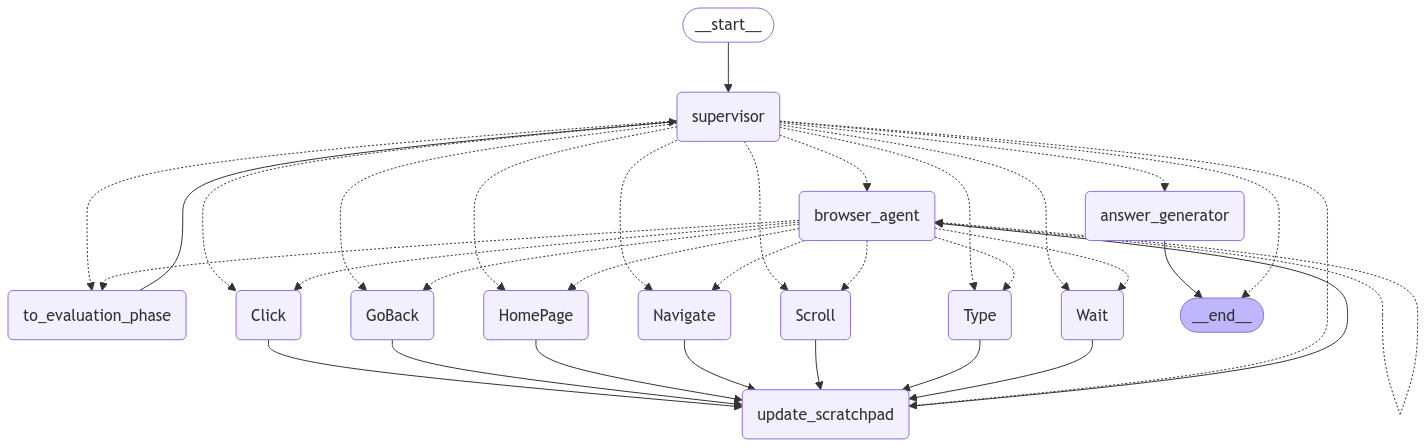

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.chromium.org")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "phase": "initial",  
        },
        {
            "recursion_limit": max_steps,
        },
    )
    
    steps = []
    current_agent = "Supervisor"
    
    async for event in event_stream:
        if "supervisor" in event:
            phase = event["supervisor"].get("phase")
            if phase == "initial":
                current_agent = "Supervisor (Planning)"
                if "browsing_instructions" in event["supervisor"]:
                    steps.append(f"{len(steps) + 1}. {current_agent}: Created browsing plan")
            elif phase == "evaluation":
                current_agent = "Supervisor (Evaluation)"
                if "supervisor_assessment" in event["supervisor"]:
                    steps.append(f"{len(steps) + 1}. {current_agent}: Evaluated browsing results")
                elif "additional_instructions" in event["supervisor"]:
                    steps.append(f"{len(steps) + 1}. {current_agent}: Requested more information")
                    
        elif "browser_agent" in event:
            current_agent = "Browser Agent"
            pred = event["browser_agent"].get("prediction") or {}
            action = pred.get("action")
            action_input = pred.get("args")
            if action:
                steps.append(f"{len(steps) + 1}. {current_agent}: {action} {action_input}")
                
        elif "answer_generator" in event:
            current_agent = "Answer Generator"
            steps.append(f"{len(steps) + 1}. {current_agent}: Generating final answer")
            
        print("\n".join(steps))
        

            
    final_answer = None
    try:

        if hasattr(event, "get") and event.get("answer_generator"):
            final_answer = event["answer_generator"]
    except Exception as e:
        print(f"Error extracting final answer: {e}")
        
    return final_answer

In [38]:
res = await call_agent("""1.Login to https://anishadesai-ta.github.io/companydemo/ and login with admin as username and password as password123.
            2.After logging in click on employee lookup tab and search for employee David Miller and generate search results
            3.Answer with David Miller's employee status and access flag""",page)
print(f"Final response: {res}")

[DEBUG] Supervisor called with phase: initial

1. Browser Agent: Navigate ['https://anishadesai-ta.github.io/companydemo/']
Trying to print https://anishadesai-ta.github.io/companydemo/
1. Browser Agent: Navigate ['https://anishadesai-ta.github.io/companydemo/']
1. Browser Agent: Navigate ['https://anishadesai-ta.github.io/companydemo/']
1. Browser Agent: Navigate ['https://anishadesai-ta.github.io/companydemo/']
2. Browser Agent: Type ['0', 'admin']
1. Browser Agent: Navigate ['https://anishadesai-ta.github.io/companydemo/']
2. Browser Agent: Type ['0', 'admin']
1. Browser Agent: Navigate ['https://anishadesai-ta.github.io/companydemo/']
2. Browser Agent: Type ['0', 'admin']
1. Browser Agent: Navigate ['https://anishadesai-ta.github.io/companydemo/']
2. Browser Agent: Type ['0', 'admin']
3. Browser Agent: Type ['1', 'password123']
1. Browser Agent: Navigate ['https://anishadesai-ta.github.io/companydemo/']
2. Browser Agent: Type ['0', 'admin']
3. Browser Agent: Type ['1', 'password123

In [ ]:
# graph_builder = StateGraph(AgentState)


# graph_builder.add_node("agent", agent)
# graph_builder.add_edge(START, "agent")

# graph_builder.add_node("update_scratchpad", update_scratchpad)
# graph_builder.add_edge("update_scratchpad", "agent")

# tools = {
#     "Click": click,
#     "Type": type_text,
#     "Scroll": scroll,
#     "Wait": wait,
#     "Navigate": go_to_url,
#     "GoBack": go_back,
#     "HomePage": to_homepage,
#     "summarize_image": summarize_image,
# }


# for node_name, tool in tools.items():
#     graph_builder.add_node(
#         node_name,
#         # The lambda ensures the function's string output is mapped to the "observation"
#         # key in the AgentState
#         RunnableLambda(tool) | (lambda observation: {"observation": observation}),
#     )
#     # Always return to the agent (by means of the update-scratchpad node)
#     graph_builder.add_edge(node_name, "update_scratchpad")


# def select_tool(state: AgentState):
#     # Any time the agent completes, this function
#     # is called to route the output to a tool or
#     # to the end user.
#     action = state["prediction"]["action"]
#     # if action.lower().startswith("answer"):
#     #     return END
#     if action == "retry":
#         return "agent"
#     return action

# graph_builder.add_node(
#         'Answer',
#         RunnableLambda(summarize_image) | (lambda observation: {"observation": observation}),
#     )
# graph_builder.add_conditional_edges("agent", select_tool)
# graph_builder.add_edge("Answer", END)

# graph = graph_builder.compile()

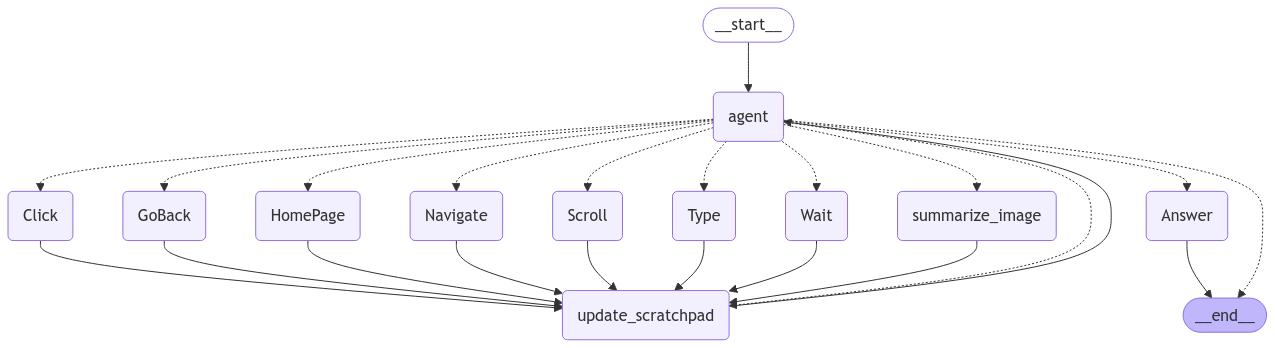

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass